# PSEI Index Price Forecasting using ARIMA model

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use('ggplot')

In [155]:
# Read & Pre-Process Dataset
df_stock = pd.read_csv('PSEI(2014-2024).csv')
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock = df_stock.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).dropna().sort_values(by='Date').set_index('Date')
df_stock

,Close
Date,
2014-04-01,6514.720215
2014-04-02,6587.720215
2014-04-03,6587.080078
2014-04-04,6561.200195
2014-04-07,6614.399902
...,...
2024-03-21,6963.220215
2024-03-22,6881.970215
2024-03-25,6853.100098


## Collection of Parameters

### ADF Test
We'll use the Augumented Dickey Fuller (ADF) test to check if the time series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

In [32]:
# Check if the price series is stationary
result = adfuller(df_stock)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.781051502805296
p-value: 0.061031817544298185


Since p-value > 0.05, we need to find the degree of differencing.

In [98]:
# Using ndiffs from pmdarima to find the degree of differencing (d)
d = ndiffs(df_stock, test='adf')
print(f'Degree of Differencing: {d}')

# Differencing the data and re-checking results
df_diff = df_stock['Close'].diff().dropna()

result = adfuller(df_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Degree of Differencing: 1
ADF Statistic: -22.838193329112862
p-value: 0.0


Now we need to find the p and q values through observation of the PACF and ACF plots

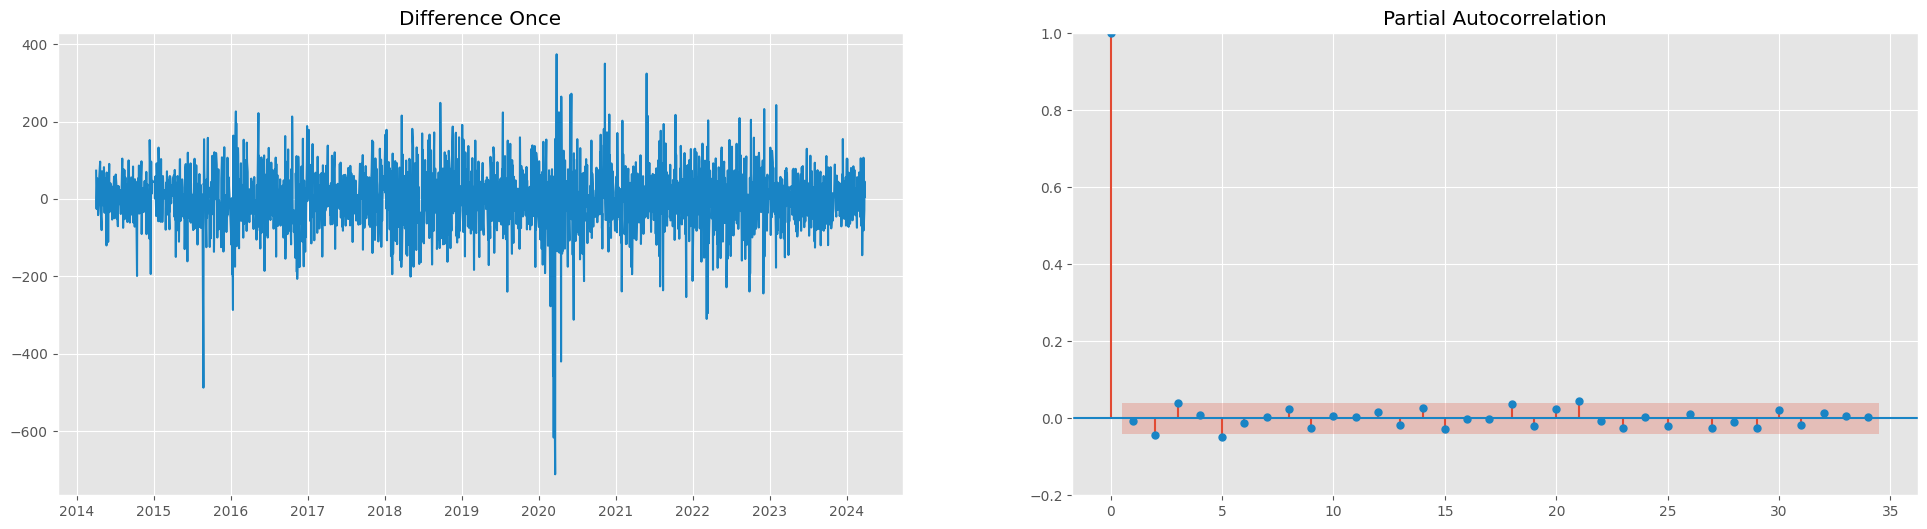

In [35]:
# Ploting PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff, color='#1984c5')
ax1.set_title('Difference Once')
plot_pacf(df_diff, ax=ax2, color='#1984c5')
ax2.set_ylim(-0.2, 1)
plt.show()

From observing the PACF plot, the order of the autoregressive model `p = 2`

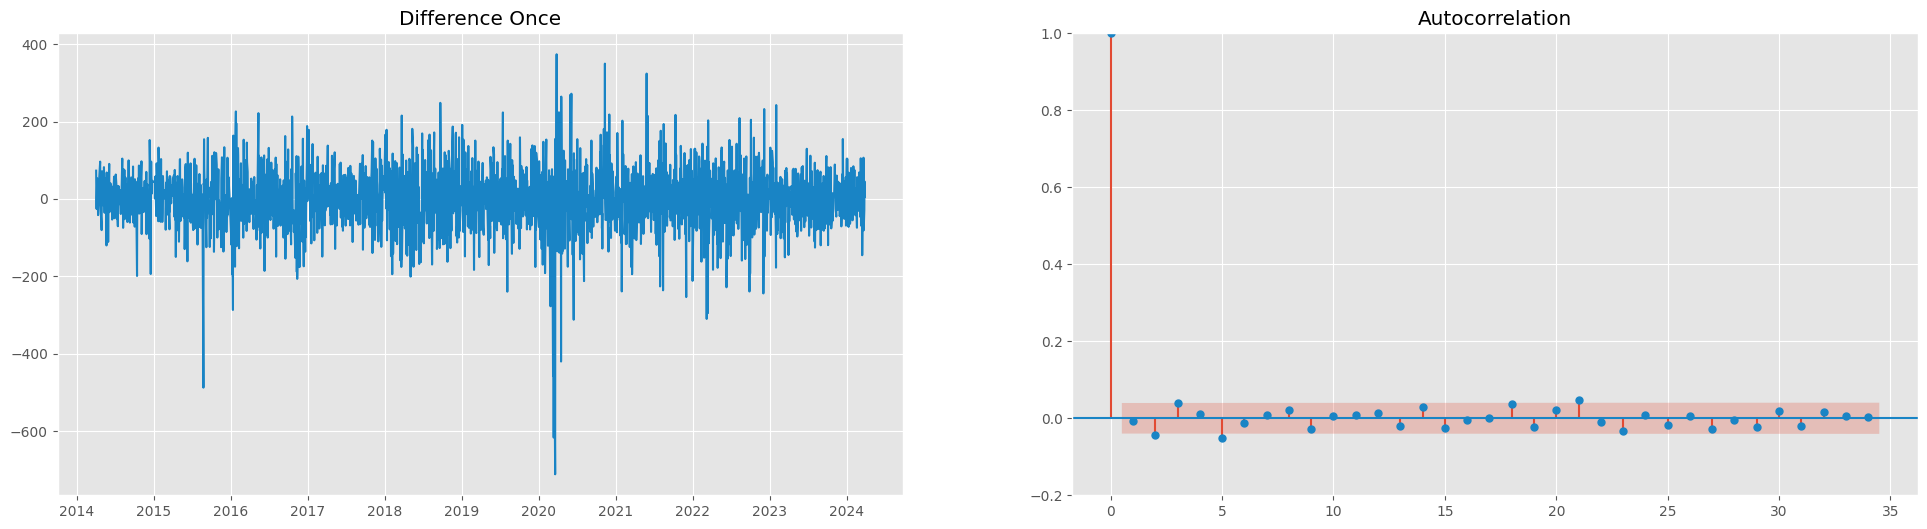

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

ax1.plot(df_diff, color='#1984c5')
ax1.set_title('Difference Once')
plot_acf(df_diff, ax=ax2, color='#1984c5')
ax2.set_ylim(-0.2, 1)
plt.show()

From observing the ACF plot, the order of the moving-average model `q = 3`

## Model Training

In summary from the previous step, we will be implementing the ARIMA model since we have all 3 required parameters. These parameters are:
* Order of the autoregressive model `p = 2`
* Degree of differencing `d = 1`
* Order of the moving-average model `q = 3`

In [248]:
model = ARIMA(df_stock['Close'].values, order=(2, 1, 3))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2436
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -14101.221
Date:                Wed, 10 Apr 2024   AIC                          28214.441
Time:                        11:00:23   BIC                          28249.227
Sample:                             0   HQIC                         28227.087
                               - 2436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4267      0.023    -18.416      0.000      -0.472      -0.381
ar.L2         -0.9611      0.022    -43.799      0.000      -1.004      -0.918
ma.L1          0.4221      0.029     14.721      0.0

## Results

### Accuracy

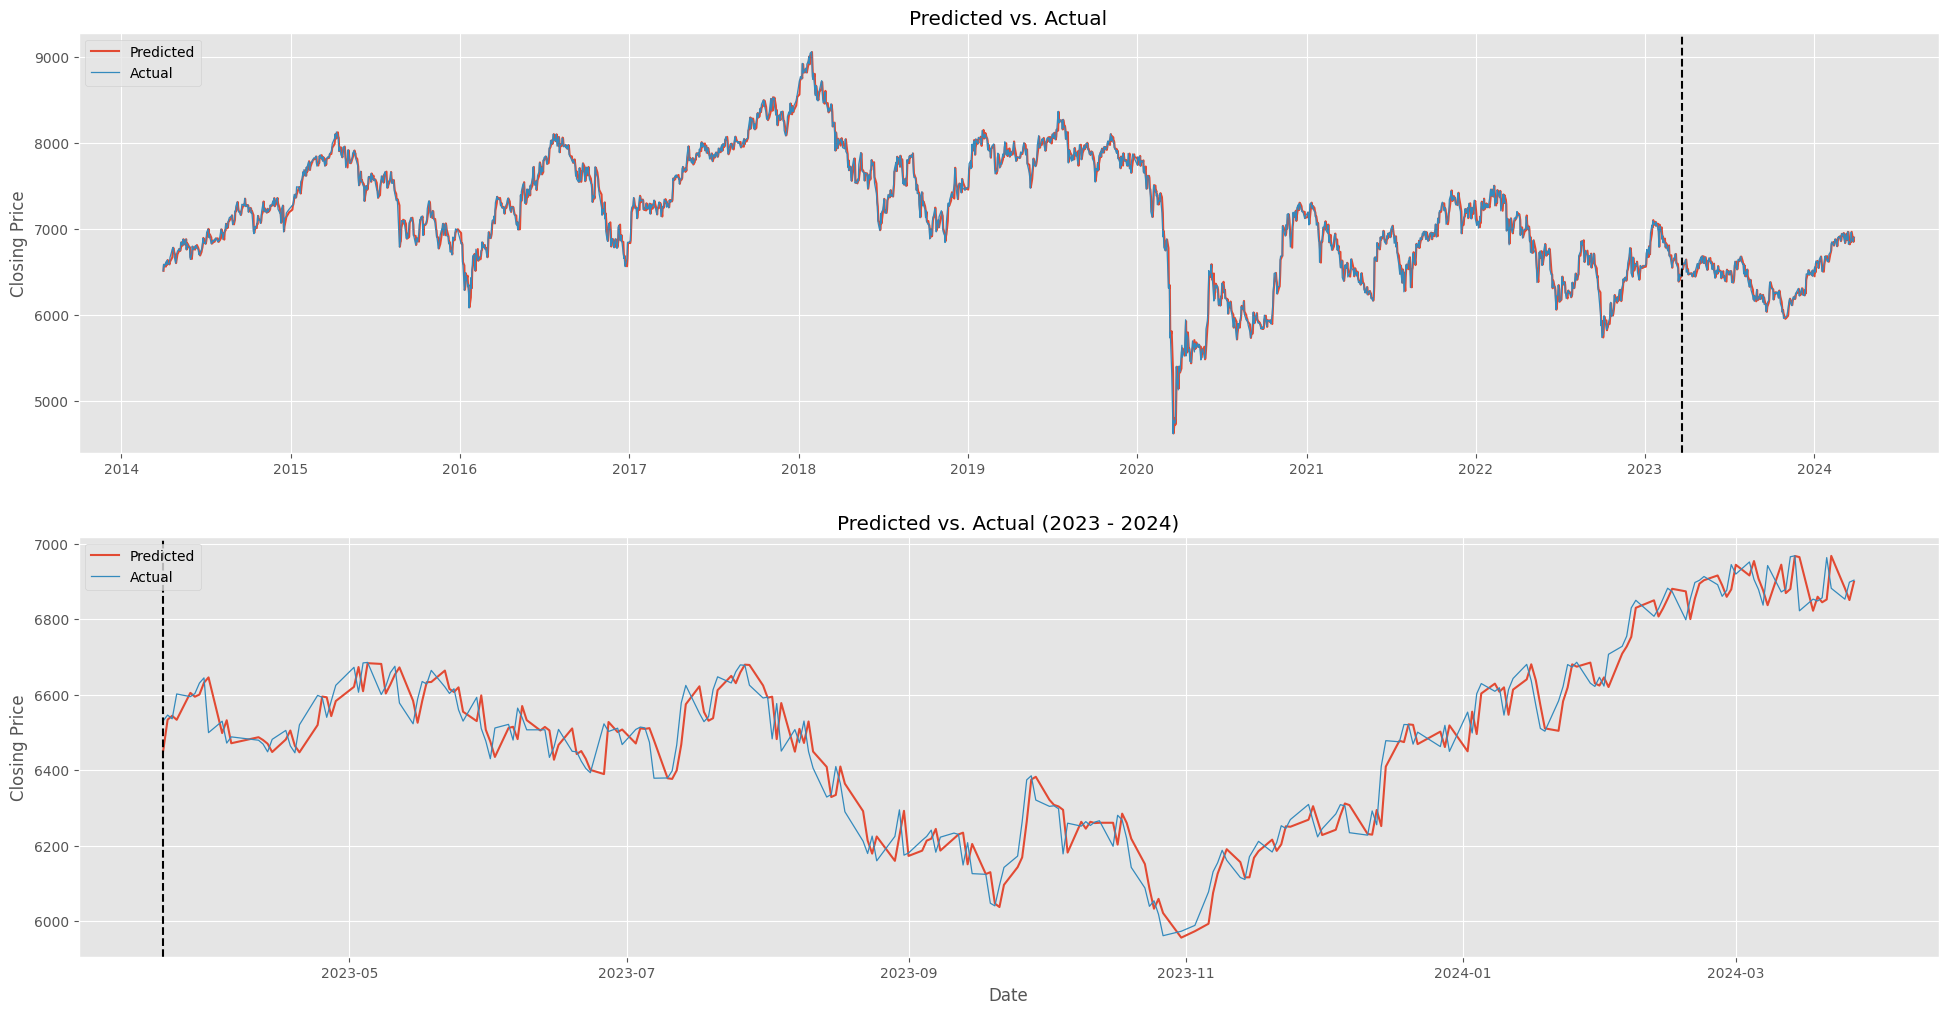

In [249]:
df_stock['Predicted'] = result.predict(dynamic=False)

plt.figure(figsize=(24, 12))

plt.subplot(2, 1 ,1)
plt.plot(df_stock['Predicted'][1:], label='Predicted')
plt.plot(df_stock['Close'], label='Actual', lw=0.9)
plt.ylabel('Closing Price')
plt.axvline(df_stock.index[2186:2187], color='black', ls='--')
plt.title('Predicted vs. Actual')
plt.legend(loc='upper left')

plt.subplot(2, 1 ,2)
plt.plot(df_stock['Predicted'][2186:], label='Predicted')
plt.plot(df_stock['Close'][2186:], label='Actual', lw=0.9)
plt.ylabel('Closing Price')
plt.xlabel('Date')
plt.axvline(df_stock.index[2186:2187], color='black', ls='--')
plt.title('Predicted vs. Actual (2023 - 2024)')
plt.legend(loc='upper left')

plt.show()

In [206]:
# Statistical Metrics
r2 = r2_score(df_stock['Close'], df_stock['Predicted'])
mae = mean_absolute_error(df_stock['Close'], df_stock['Predicted'])

print(f'R-Squared: {r2}')
print(f'MAE: {mae}')

R-Squared: 0.9499702281497232
MAE: 60.85957005657869


* R-Squared: A value of 0.95 indicates that the model explains 95% of the variance in the stock prices. This suggest the the model is performing well in predicting stock prices.
* Mean Absolute Error: A value of 60.86 indicates that on average the model's prediction are off by approximately 60.86. This suggest that the model is relatively accurate with errors that are around 1% of the stock price range.

### Forecast

We will only be forecasting 30 days into the future since ARIMA is not that reliable in forecasting long term.

In [253]:
forecast = result.forecast(steps=23)
last_date = df_stock.index[-1]
future_date = pd.bdate_range(start=last_date + pd.DateOffset(days=1), periods=23)
df_forecast = pd.DataFrame()
df_forecast['Date'] = future_date
df_forecast['Close'] = forecast
df_forecast

,Date,Close
0,2024-03-28,6904.076161
1,2024-03-29,6902.472671
2,2024-04-01,6902.630324
3,2024-04-02,6904.104155
4,2024-04-03,6903.323790
5,2024-04-04,6902.240269
6,2024-04-05,6903.452581
7,2024-04-08,6903.976678
8,2024-04-09,6902.587919
9,2024-04-10,6902.676763


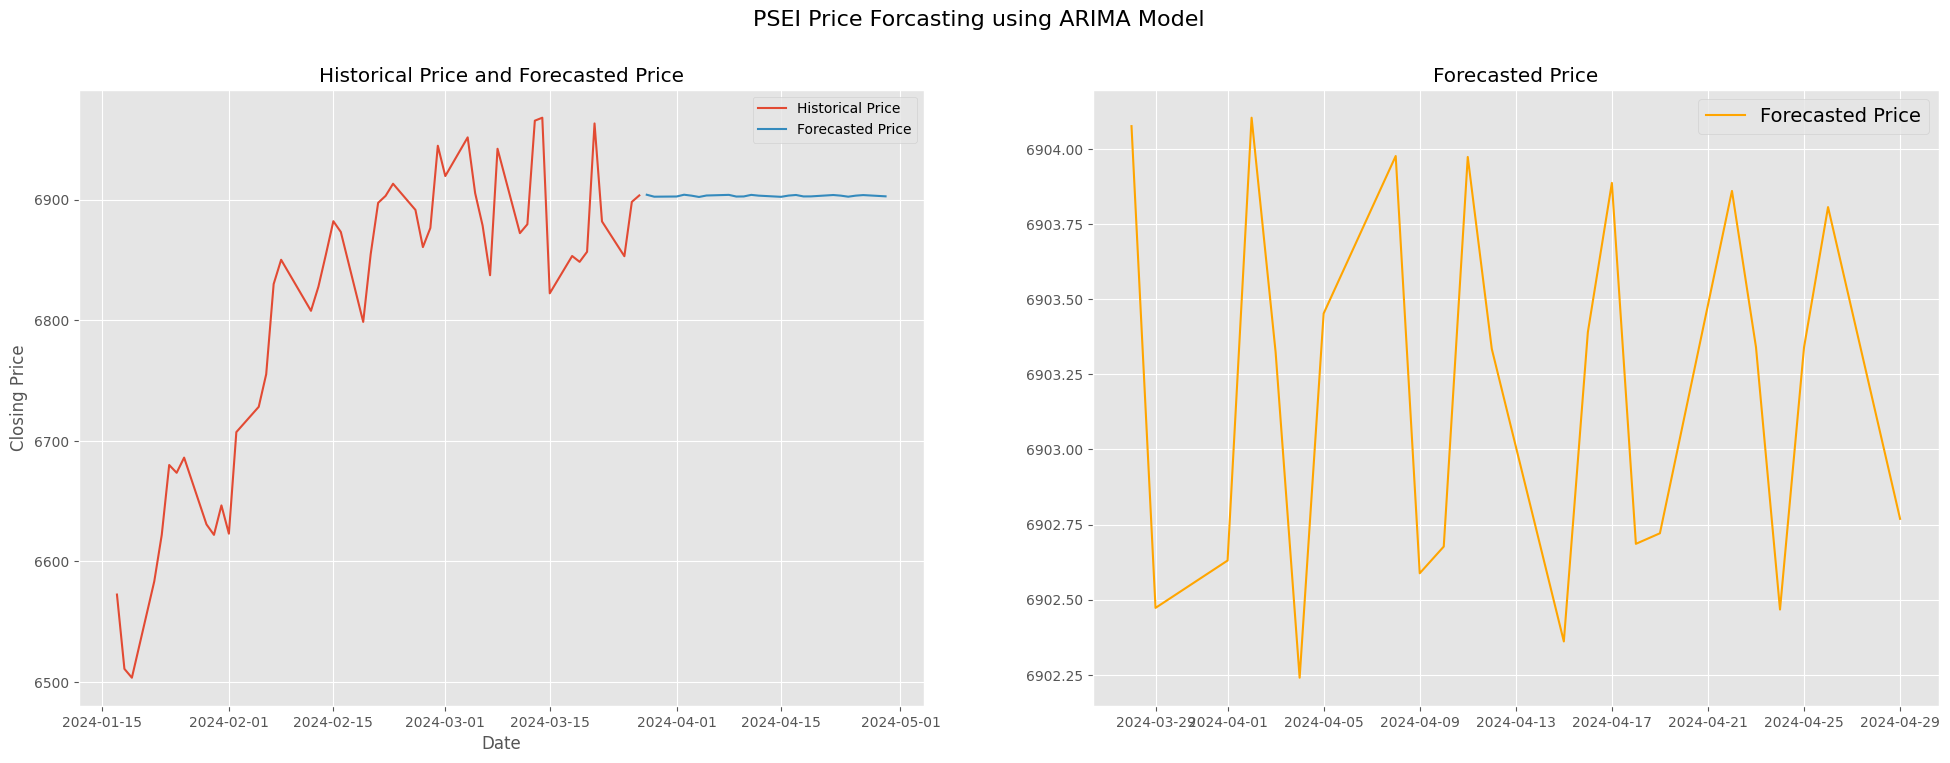

In [209]:
# Visualize results
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(df_stock.index[2386:], df_stock['Close'][2386:], label = 'Historical Price')
plt.plot(df_forecast['Date'], df_forecast['Close'], label = 'Forecasted Price')
plt.title('Historical Price and Forecasted Price')
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.subplot(1, 2, 2)
plt.plot(future_date, forecast, color='orange' ,label = 'Forecasted Price')
plt.title('Forecasted Price')
plt.legend(loc='upper right')
plt.suptitle('PSEI Price Forcasting using ARIMA Model', fontsize=16)
plt.show()